<a href="https://colab.research.google.com/github/dylanbforde/ai-medical-image-analysis/blob/main/MRNET_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchsample
!pip install visdom
!pip install nibabel
!pip install h5py
!pip install tensorboardX
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.6/393.6 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/

In [3]:
import optuna
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import sys
import pickle
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
from torchvision import transforms
from tensorboardX import SummaryWriter
import math
from sklearn import metrics


In [10]:
# Modify the Net class to use R2Plus1D_18
import torchvision.models.video as video_models

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pretrained R2Plus1D_18 model
        self.pretrained_model = video_models.r2plus1d_18(pretrained=True)

        # Modify the last fully connected layer to output (1)
        # The in_features for R2Plus1D_18's fc layer is 512
        self.classifer = nn.Linear(self.pretrained_model.fc.in_features, 1)

        # Add a Dropout layer after the classifier
        self.dropout = nn.Dropout(0.5) # Experiment with a dropout rate of 0.5

        # Remove the original fully connected layer from the pretrained model
        self.pretrained_model.fc = nn.Identity()


    def forward(self, x):
        # input size of x (batch_size, s, 3, 256, 256) where s is the number of slices in one MRI
        # R2Plus1D_18 expects input in (batch_size, channels, time, height, width) format
        # Permute the input to match the expected format (batch_size, 3, s, 256, 256)
        x = x.permute(0, 2, 1, 3, 4) # output size (batch_size, 3, num_slices, 256, 256)

        x = self.pretrained_model(x) # output size (batch_size, 512)

        # Pass through classifier
        output = self.classifer(x) # output size (batch_size, 1)

        # Apply dropout
        output = self.dropout(output)

        return output

# Re-initialize the model with the new architecture
model = Net()
if torch.cuda.is_available():
    model = model.cuda()

# Keep the existing optimizer, scheduler, and data loaders
# (These are defined in the previous cells and will be used in the training loop)

print("Model architecture modified to use R2Plus1D_18 model.")
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:01<00:00, 89.0MB/s]


Model architecture modified to use R2Plus1D_18 model.
Net(
  (pretrained_model): VideoResNet(
    (stem): R2Plus1dStem(
      (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv2Plus1D(
            (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
            (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0),

In [11]:
class Dataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=False, transform=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train=train
        if self.train == True:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)

            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        # Limit the number of samples for training
        if self.train and len(self.records) > 100:
            self.records = self.records.sample(100, random_state=42).reset_index(drop=True)


        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform

        # Add a resize transform to reduce image dimensions
        self.resize_transform = transforms.Resize((128, 128))


        pos = np.sum(self.labels)
        neg = len(self.labels) - pos
        self.weights = [1, neg / pos]


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])

        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:
          transformed_slices = []
          for i in array:
            # Apply transform to each slice
            transformed_slice = self.transform(i)
            transformed_slice = transformed_slice.repeat(3, 1, 1)
            # Apply resize after other transforms
            transformed_slice = self.resize_transform(transformed_slice)
            transformed_slices.append(transformed_slice)
          array = torch.stack(transformed_slices)
        else:
          array = torch.from_numpy(array).float()
          array = array.unsqueeze(1)
          array = array.repeat(1, 3, 1, 1)
          # Apply resize when no other transforms are used
          array = self.resize_transform(array)


        array = array.float()

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        if array.shape[0] < 32:
            zeros = torch.zeros((32 - array.shape[0], 3, 128, 128)) # Update zeros size for resizing
            array = torch.cat((array, zeros), 0)

        elif array.shape[0] > 32:
            array = array[:32, :, :, :]

        return array, label, weight

In [ ]:
def objective(trial):
    # Print statement at the beginning of each trial
    print(f"Starting trial {trial.number}...")

    # Define the hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [1, 2]) # Example batch sizes - further reduced
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6) # Tune dropout rate
    trial_number = trial.number

    # Print suggested hyperparameters for the current trial
    print(f"  Trial {trial.number} hyperparameters: lr={lr:.6f}, weight_decay={weight_decay:.6f}, batch_size={batch_size}, dropout_rate={dropout_rate:.4f}")


    # --- Model Initialization ---
    model = Net()
    # Update the dropout rate in the model with the suggested value from Optuna
    model.dropout.p = dropout_rate

    if torch.cuda.is_available():
        model = model.cuda()

    # Change the optimizer to AdamW
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=2, factor=.3, threshold=1e-4, verbose=False) # Reduced patience for tuning

    # --- Data Loading ---
    directory = "/content/drive/Shared drives/MRNet Group Assignment/MRI Data/"
    task = 'acl'
    plane = 'sagittal'

    augmentor = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(25),
        transforms.RandomAffine(degrees=0, translate=(0.11, 0.11)),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)) # Added Gaussian Blur
    ])

    train_dataset = Dataset(directory, task, plane, train=True, transform=augmentor)
    valid_dataset = Dataset(directory, task, plane, train=False, transform = None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=False)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

    # Print data loading information
    print(f"  Trial {trial.number}: Training data loaded ({len(train_dataset)} samples), Validation data loaded ({len(valid_dataset)} samples)")


    # --- Training Loop (Shortened for Tuning) ---
    num_tuning_epochs = 5 # Reduced number of epochs for faster tuning trials
    best_val_auc = 0
    train_losses = []
    val_losses = []

    print(f"  Trial {trial.number}: Starting training for {num_tuning_epochs} epochs...")

    for epoch in range(num_tuning_epochs):
        model.train()
        y_preds = []
        y_trues = []
        running_loss = 0.0
        for i, (image, label, weight) in enumerate(train_loader):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()
                weight = weight.cuda()

            prediction = model.forward(image.float())
            loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            probas = torch.sigmoid(prediction)
            y_trues.extend(label.cpu().tolist())
            y_preds.extend(probas.cpu().tolist())
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on validation set
        model.eval()
        y_trues_val = []
        y_preds_val = []
        running_val_loss = 0.0
        with torch.no_grad():
            for i, (image, label, weight) in enumerate(valid_loader):
                if torch.cuda.is_available():
                    image = image.cuda()
                    label = label.cuda()
                    weight = weight.cuda()

                prediction = model.forward(image.float())
                loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
                running_val_loss += loss.item()
                probas = torch.sigmoid(prediction)
                y_trues_val.extend(label.cpu().tolist())
                y_preds_val.extend(probas.cpu().tolist())
        avg_val_loss = running_val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)


        try:
            val_auc = metrics.roc_auc_score(y_trues_val, y_preds_val)
        except:
            val_auc = 0.5 # Handle case with only one class

        # Print epoch-wise progress
        print(f"  Trial {trial.number}, Epoch {epoch+1}/{num_tuning_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val AUC = {val_auc:.4f}")


        # Report intermediate objective value to Optuna
        trial.report(val_auc, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            print(f"  Trial {trial.number} pruned at epoch {epoch+1}.")
            raise optuna.exceptions.TrialPruned()

        if val_auc > best_val_auc:
            best_val_auc = val_auc

    # Store training and validation losses in trial user attributes
    trial.set_user_attr("train_losses", train_losses)
    trial.set_user_attr("val_losses", val_losses)

    model_save_path = f'/content/drive/MyDrive/my_acl_sagittal_model_trial_{trial_number}.pth'

    # Save the model's state dictionary
    torch.save(model.state_dict(), model_save_path)
    print(f"  Trial {trial.number}: Model saved to {model_save_path}")


    # Print statement at the end of each trial
    print(f"Finished trial {trial.number}. Best Validation AUC: {best_val_auc:.4f}")


    return best_val_auc # Return the best validation AUC for this trial

# --- Run the Optuna study ---
# Specify the number of trials to run. Keep this small initially to manage computation cost.
n_trials = 10 # You can increase this number for a more extensive search, however my compute credits are low

print(f"Running Optuna study for {n_trials} trials...")

# Create a study object and specify the direction (maximize validation AUC)
study = optuna.create_study(direction='maximize')

# Run the optimization study
study.optimize(objective, n_trials=n_trials, n_jobs=1)

print("\nOptuna study finished.")

# Print the best trial's hyperparameters and value
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-06-29 11:02:14,715] A new study created in memory with name: no-name-4666be6b-e132-470e-b016-e174ac4c1ed7


Running Optuna study for 10 trials...
Starting trial 0...
  Trial 0 hyperparameters: lr=0.000054, weight_decay=0.000895, batch_size=2, dropout_rate=0.2989


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 0: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 0: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 0, Epoch 1/5: Train Loss = 1.0298, Val Loss = 19.5214, Val AUC = 0.5550
  Trial 0, Epoch 2/5: Train Loss = 0.9942, Val Loss = 23.7293, Val AUC = 0.5662
  Trial 0, Epoch 3/5: Train Loss = 0.8757, Val Loss = 18.7639, Val AUC = 0.5491
  Trial 0, Epoch 4/5: Train Loss = 1.0248, Val Loss = 14.8047, Val AUC = 0.5441
  Trial 0, Epoch 5/5: Train Loss = 0.8820, Val Loss = 7.4129, Val AUC = 0.5272


[I 2025-06-29 11:03:51,146] Trial 0 finished with value: 0.5662177328843996 and parameters: {'lr': 5.408007422442496e-05, 'weight_decay': 0.0008950972402859121, 'batch_size': 2, 'dropout_rate': 0.2989188801919488}. Best is trial 0 with value: 0.5662177328843996.


  Trial 0: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_0.pth
Finished trial 0. Best Validation AUC: 0.5662
Starting trial 1...
  Trial 1 hyperparameters: lr=0.000006, weight_decay=0.000085, batch_size=2, dropout_rate=0.5322


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 1: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 1: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 1, Epoch 1/5: Train Loss = 1.0201, Val Loss = 3.8619, Val AUC = 0.4543
  Trial 1, Epoch 2/5: Train Loss = 1.0354, Val Loss = 2.3710, Val AUC = 0.4602
  Trial 1, Epoch 3/5: Train Loss = 1.0524, Val Loss = 2.4631, Val AUC = 0.4691
  Trial 1, Epoch 4/5: Train Loss = 1.0117, Val Loss = 1.3914, Val AUC = 0.4604
  Trial 1, Epoch 5/5: Train Loss = 0.9739, Val Loss = 1.7723, Val AUC = 0.4815


[I 2025-06-29 11:04:59,186] Trial 1 finished with value: 0.48148148148148145 and parameters: {'lr': 5.650758076548514e-06, 'weight_decay': 8.539972073141311e-05, 'batch_size': 2, 'dropout_rate': 0.5321510808427835}. Best is trial 0 with value: 0.5662177328843996.


  Trial 1: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_1.pth
Finished trial 1. Best Validation AUC: 0.4815
Starting trial 2...
  Trial 2 hyperparameters: lr=0.000008, weight_decay=0.000017, batch_size=2, dropout_rate=0.2166


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 2: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 2: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 2, Epoch 1/5: Train Loss = 1.0308, Val Loss = 8.1653, Val AUC = 0.7172
  Trial 2, Epoch 2/5: Train Loss = 1.0122, Val Loss = 8.3116, Val AUC = 0.6787
  Trial 2, Epoch 3/5: Train Loss = 0.9643, Val Loss = 6.9035, Val AUC = 0.6768
  Trial 2, Epoch 4/5: Train Loss = 0.9091, Val Loss = 8.0804, Val AUC = 0.6754
  Trial 2, Epoch 5/5: Train Loss = 0.8614, Val Loss = 8.0931, Val AUC = 0.6706


[I 2025-06-29 11:06:06,537] Trial 2 finished with value: 0.7171717171717172 and parameters: {'lr': 8.470059087411959e-06, 'weight_decay': 1.7172388899258975e-05, 'batch_size': 2, 'dropout_rate': 0.21661396617499554}. Best is trial 2 with value: 0.7171717171717172.


  Trial 2: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_2.pth
Finished trial 2. Best Validation AUC: 0.7172
Starting trial 3...
  Trial 3 hyperparameters: lr=0.000003, weight_decay=0.000016, batch_size=2, dropout_rate=0.5745


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 3: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 3: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 3, Epoch 1/5: Train Loss = 1.0702, Val Loss = 6.8625, Val AUC = 0.6667
  Trial 3, Epoch 2/5: Train Loss = 1.0208, Val Loss = 9.2932, Val AUC = 0.6686
  Trial 3, Epoch 3/5: Train Loss = 1.0587, Val Loss = 8.3218, Val AUC = 0.6641
  Trial 3, Epoch 4/5: Train Loss = 1.0140, Val Loss = 7.0263, Val AUC = 0.6953
  Trial 3, Epoch 5/5: Train Loss = 1.0683, Val Loss = 6.8345, Val AUC = 0.6922


[I 2025-06-29 11:07:14,324] Trial 3 finished with value: 0.6952861952861952 and parameters: {'lr': 2.867273066682664e-06, 'weight_decay': 1.638192070596246e-05, 'batch_size': 2, 'dropout_rate': 0.5745131326724533}. Best is trial 2 with value: 0.7171717171717172.


  Trial 3: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_3.pth
Finished trial 3. Best Validation AUC: 0.6953
Starting trial 4...
  Trial 4 hyperparameters: lr=0.000028, weight_decay=0.000260, batch_size=1, dropout_rate=0.2485


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 4: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 4: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 4, Epoch 1/5: Train Loss = 1.0504, Val Loss = 9.2460, Val AUC = 0.3356
  Trial 4, Epoch 2/5: Train Loss = 0.9925, Val Loss = 9.9427, Val AUC = 0.3549
  Trial 4, Epoch 3/5: Train Loss = 0.9809, Val Loss = 9.4626, Val AUC = 0.3569
  Trial 4, Epoch 4/5: Train Loss = 0.9906, Val Loss = 12.9410, Val AUC = 0.4889
  Trial 4, Epoch 5/5: Train Loss = 0.9386, Val Loss = 13.3928, Val AUC = 0.4891


[I 2025-06-29 11:08:22,800] Trial 4 finished with value: 0.4890572390572391 and parameters: {'lr': 2.761977015014108e-05, 'weight_decay': 0.00026012830553226717, 'batch_size': 1, 'dropout_rate': 0.24851528949705734}. Best is trial 2 with value: 0.7171717171717172.


  Trial 4: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_4.pth
Finished trial 4. Best Validation AUC: 0.4891
Starting trial 5...
  Trial 5 hyperparameters: lr=0.000003, weight_decay=0.000016, batch_size=2, dropout_rate=0.1382


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 5: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 5: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 5, Epoch 1/5: Train Loss = 1.0166, Val Loss = 10.2547, Val AUC = 0.6338
  Trial 5, Epoch 2/5: Train Loss = 0.9823, Val Loss = 12.8895, Val AUC = 0.5227
  Trial 5, Epoch 3/5: Train Loss = 0.9547, Val Loss = 11.8452, Val AUC = 0.5673
  Trial 5, Epoch 4/5: Train Loss = 0.9627, Val Loss = 13.0705, Val AUC = 0.5227
  Trial 5, Epoch 5/5: Train Loss = 0.9164, Val Loss = 13.4297, Val AUC = 0.5076


[I 2025-06-29 11:09:30,212] Trial 5 finished with value: 0.6338383838383839 and parameters: {'lr': 3.3568313259212307e-06, 'weight_decay': 1.550067811873209e-05, 'batch_size': 2, 'dropout_rate': 0.13821435459285}. Best is trial 2 with value: 0.7171717171717172.


  Trial 5: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_5.pth
Finished trial 5. Best Validation AUC: 0.6338
Starting trial 6...
  Trial 6 hyperparameters: lr=0.000032, weight_decay=0.000205, batch_size=1, dropout_rate=0.3113


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 6: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 6: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-06-29 11:09:44,272] Trial 6 pruned. 


  Trial 6, Epoch 1/5: Train Loss = 1.1031, Val Loss = 8.3301, Val AUC = 0.3970
  Trial 6 pruned at epoch 1.
Starting trial 7...
  Trial 7 hyperparameters: lr=0.000052, weight_decay=0.000035, batch_size=2, dropout_rate=0.1911


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 7: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 7: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Trial 7, Epoch 1/5: Train Loss = 0.9777, Val Loss = 5.7890, Val AUC = 0.6466
  Trial 7, Epoch 2/5: Train Loss = 0.9733, Val Loss = 11.0502, Val AUC = 0.6338
  Trial 7, Epoch 3/5: Train Loss = 0.9102, Val Loss = 5.4885, Val AUC = 0.6308
  Trial 7, Epoch 4/5: Train Loss = 0.9687, Val Loss = 11.9260, Val AUC = 0.6215
  Trial 7, Epoch 5/5: Train Loss = 0.9063, Val Loss = 19.2174, Val AUC = 0.6162


[I 2025-06-29 11:10:51,157] Trial 7 finished with value: 0.6466049382716049 and parameters: {'lr': 5.167633273936178e-05, 'weight_decay': 3.472387396553605e-05, 'batch_size': 2, 'dropout_rate': 0.19108228089256366}. Best is trial 2 with value: 0.7171717171717172.


  Trial 7: Model saved to /content/drive/MyDrive/my_acl_sagittal_model_trial_7.pth
Finished trial 7. Best Validation AUC: 0.6466
Starting trial 8...
  Trial 8 hyperparameters: lr=0.000004, weight_decay=0.000128, batch_size=2, dropout_rate=0.3155


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 8: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 8: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-06-29 11:11:05,088] Trial 8 pruned. 


  Trial 8, Epoch 1/5: Train Loss = 1.0191, Val Loss = 3.7339, Val AUC = 0.4248
  Trial 8 pruned at epoch 1.
Starting trial 9...
  Trial 9 hyperparameters: lr=0.000001, weight_decay=0.000012, batch_size=1, dropout_rate=0.1826


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Trial 9: Training data loaded (100 samples), Validation data loaded (120 samples)
  Trial 9: Starting training for 5 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-06-29 11:11:19,105] Trial 9 pruned. 


  Trial 9, Epoch 1/5: Train Loss = 0.9953, Val Loss = 25.8547, Val AUC = 0.5000
  Trial 9 pruned at epoch 1.

Optuna study finished.
Best trial:
  Value: 0.7171717171717172
  Params: 
    lr: 8.470059087411959e-06
    weight_decay: 1.7172388899258975e-05
    batch_size: 2
    dropout_rate: 0.21661396617499554


Visualizing training and validation losses for all trials...
Loss data not found for Trial 6
Loss data not found for Trial 8
Loss data not found for Trial 9


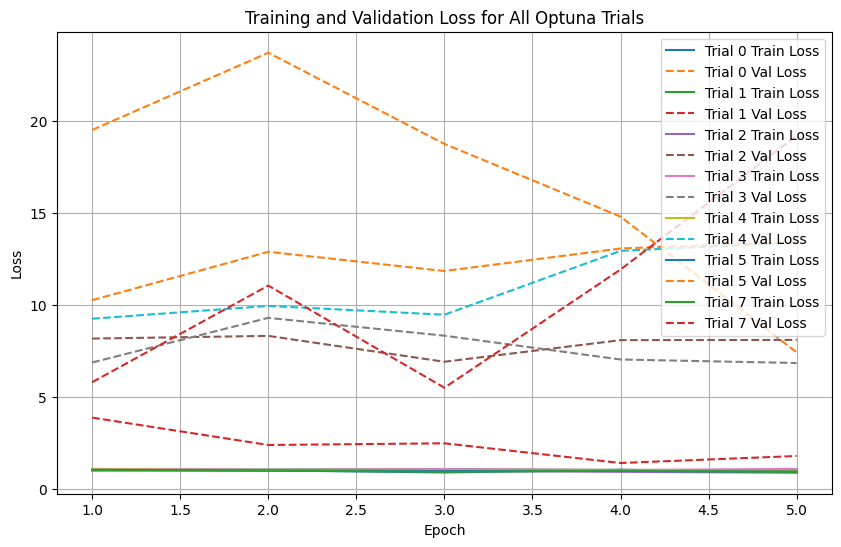

Visualization complete.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

print("Visualizing training and validation losses for all trials...")

plt.figure(figsize=(10, 6)) # Create a single figure for all plots

for trial in study.trials:
    trial_number = trial.number
    train_losses = trial.user_attrs.get("train_losses")
    val_losses = trial.user_attrs.get("val_losses")

    if train_losses is not None and val_losses is not None:
        epochs = range(1, len(train_losses) + 1)

        plt.plot(epochs, train_losses, label=f'Trial {trial_number} Train Loss')
        plt.plot(epochs, val_losses, label=f'Trial {trial_number} Val Loss', linestyle='--')
    else:
        print(f"Loss data not found for Trial {trial_number}")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for All Optuna Trials')
plt.legend()
plt.grid(True)
plt.show()

print("Visualization complete.")

In [ ]:
print("\nBest trial AUC:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


Best trial AUC:
  Value: 0.7171717171717172
  Params: 
    lr: 8.470059087411959e-06
    weight_decay: 1.7172388899258975e-05
    batch_size: 2
    dropout_rate: 0.21661396617499554


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Examples of Classifications:
------------------------------
Correct Classifications:
Example 1: Predicted Probability = 0.0000, True Label = 0


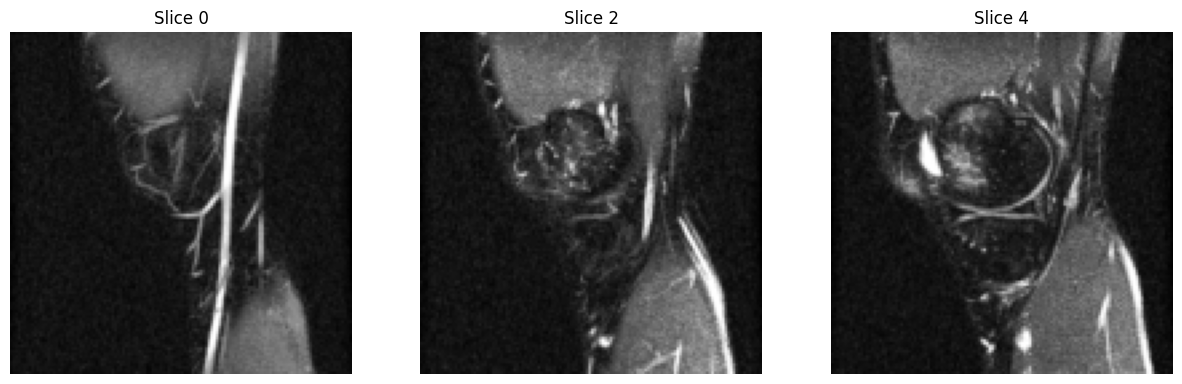

------------------------------
Example 2: Predicted Probability = 0.0000, True Label = 0


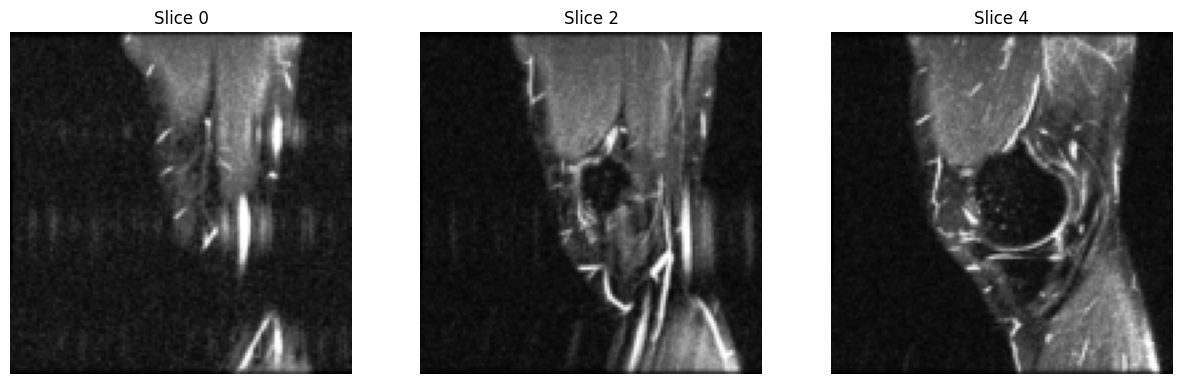

------------------------------
Example 3: Predicted Probability = 0.0000, True Label = 0


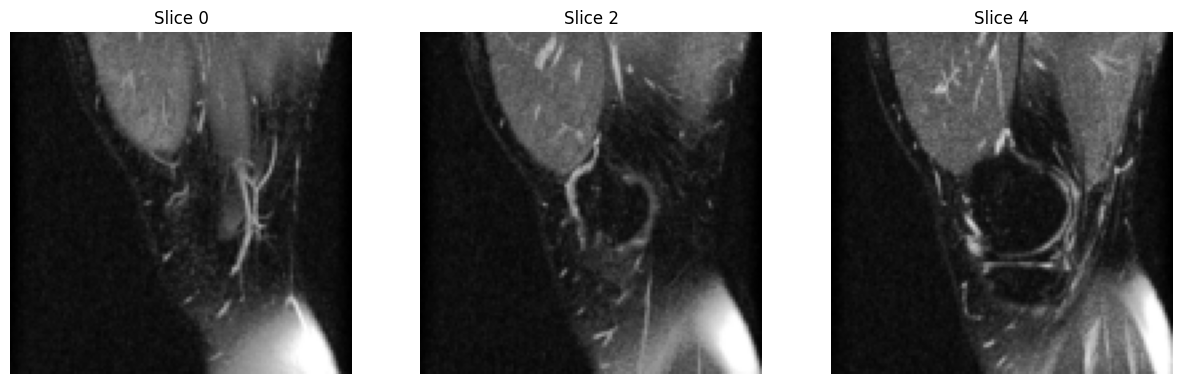

------------------------------
Incorrect Classifications:
Example 1: Predicted Probability = 0.0000, True Label = 1


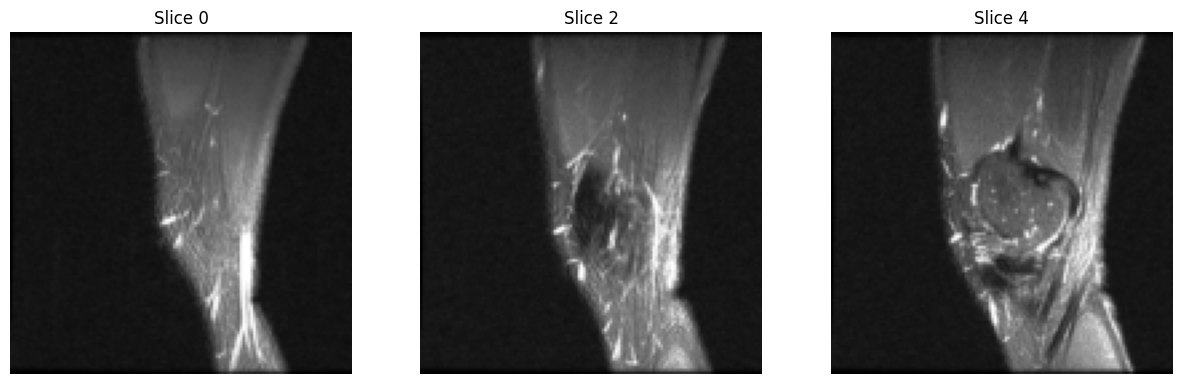

------------------------------
Example 2: Predicted Probability = 0.0000, True Label = 1


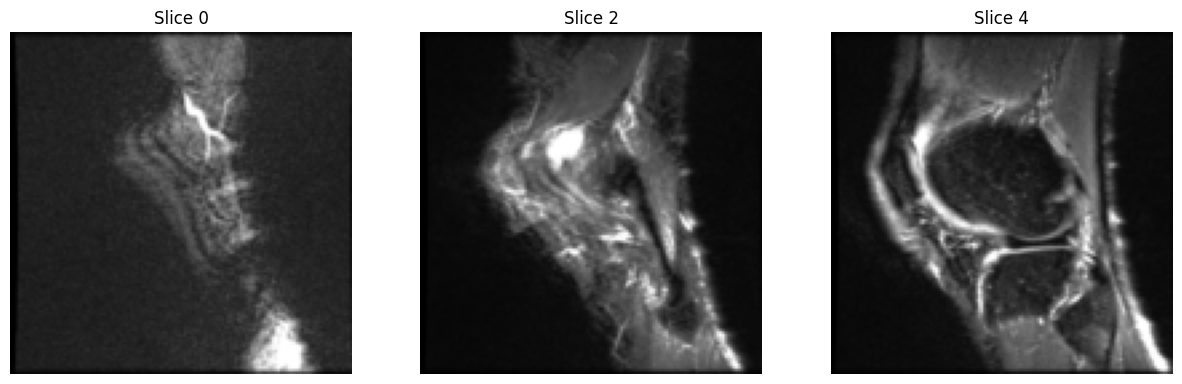

------------------------------
Example 3: Predicted Probability = 0.0000, True Label = 1


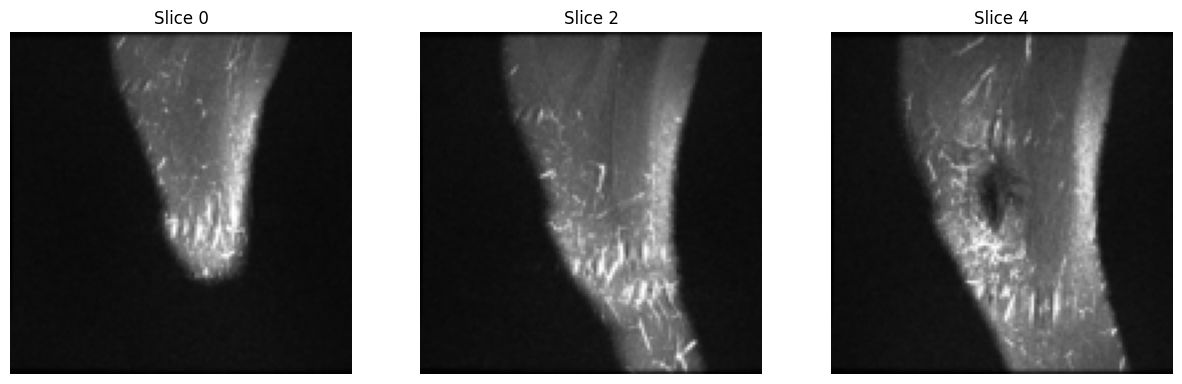

------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import transforms
import pandas as pd
import torch.utils.data as data # Import data here if not already imported globally


# Get the best trial and its parameters
best_trial = study.best_trial
best_batch_size = best_trial.params['batch_size']
best_trial_number = best_trial.number


directory = "/content/drive/Shared drives/MRNet Group Assignment/MRI Data/"
task = 'acl'
plane = 'sagittal'

valid_dataset = Dataset(directory, task, plane, train=False, transform = None)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=best_batch_size, shuffle=False, num_workers=2, drop_last=False)


model = Net() # Initialize the model
model_save_path = f'/content/drive/MyDrive/my_acl_sagittal_model_trial_{best_trial_number}.pth'
model.load_state_dict(torch.load(model_save_path)) # Load the saved state
if torch.cuda.is_available():
    model = model.cuda()
model.eval()


y_trues = []
y_preds = []
examples = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for i, (image, label, weight) in enumerate(valid_loader):
        if torch.cuda.is_available():
            # Keep image on GPU for prediction, but will move to CPU for display later
            image_gpu = image.cuda()
        else:
            image_gpu = image

        prediction = model.forward(image_gpu.float())
        probas = torch.sigmoid(prediction)

        y_trues.extend(label.cpu().tolist())
        y_preds.extend(probas.cpu().tolist())

        # Store examples with predictions, true labels, and the image data (on CPU)
        for j in range(image.size(0)):
            examples.append({
                'predicted_proba': probas[j].item(),
                'true_label': label[j].item(),
                'image': image[j].cpu().numpy() # Store image data on CPU
            })

# Display some examples
print("Examples of Classifications:")
print("-" * 30)

# Display a few correct classifications
print("Correct Classifications:")
correct_examples = [ex for ex in examples if (ex['predicted_proba'] > 0.5 and ex['true_label'] == 1.0) or (ex['predicted_proba'] <= 0.5 and ex['true_label'] == 0.0)]
for i, ex in enumerate(correct_examples[:3]): # Display up to 3 correct examples
    print(f"Example {i+1}: Predicted Probability = {ex['predicted_proba']:.4f}, True Label = {int(ex['true_label'])}")
    img_data = ex['image'] # Shape is (num_slices, channels, height, width)
    num_slices = img_data.shape[0]
    # Display a few slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices_to_show = [0, 2, 4] # Display first, third, and fifth slices
    for k, slice_idx in enumerate(slices_to_show):
        if slice_idx < num_slices:
            # Assuming grayscale image with 3 repeated channels, take one channel
            axes[k].imshow(img_data[slice_idx, 0, :, :], cmap='gray')
            axes[k].set_title(f"Slice {slice_idx}")
            axes[k].axis('off')
    plt.show()
    print("-" * 30)


# Display a few incorrect classifications
print("Incorrect Classifications:")
incorrect_examples = [ex for ex in examples if (ex['predicted_proba'] > 0.5 and ex['true_label'] == 0.0) or (ex['predicted_proba'] <= 0.5 and ex['true_label'] == 1.0)]
for i, ex in enumerate(incorrect_examples[:3]): # Display up to 3 incorrect examples
    print(f"Example {i+1}: Predicted Probability = {ex['predicted_proba']:.4f}, True Label = {int(ex['true_label'])}")
    img_data = ex['image'] # Shape is (num_slices, channels, height, width)
    num_slices = img_data.shape[0]
    # Display a few slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices_to_show = [0, 2, 4] # Display first, third, and fifth slices
    for k, slice_idx in enumerate(slices_to_show):
         if slice_idx < num_slices:
            axes[k].imshow(img_data[slice_idx, 0, :, :], cmap='gray')
            axes[k].set_title(f"Slice {slice_idx}")
            axes[k].axis('off')
    plt.show()
    print("-" * 30)

In [22]:
from sklearn import metrics

task = 'acl'
plane = 'sagittal'
best_model_path = "/content/drive/Shareddrives/MRNet Group Assignment/my_acl_sagittal_model_trial_7.pth"
data_dir = "/content/drive/Shareddrives/MRNet Group Assignment/MRI Data/"




In [23]:
model = Net()
state_dict = torch.load(best_model_path)
model.load_state_dict(state_dict)
model.eval()
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
from torch.utils.data import DataLoader

test_dataset = Dataset(data_dir, task, plane, train=True, transform=None)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [25]:
y_trues = []
y_probs = []

with torch.no_grad():
    for images, labels, weights in test_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images.float())
        probs = torch.sigmoid(outputs.squeeze(0))

        y_trues.append(int(labels.item()))
        y_probs.append(probs.item())

#probabilities to binary predictions
y_preds = [1 if p >= 0.5 else 0 for p in y_probs]


test_accuracy = metrics.accuracy_score(y_trues, y_preds)
test_f1 = metrics.f1_score(y_trues, y_preds)
test_auc = metrics.roc_auc_score(y_trues, y_probs)

print(f" Final Evaluation Metrics on Hold-out Test Set:")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")
print(f"Test AUC      : {test_auc:.4f}")

 Final Evaluation Metrics on Hold-out Test Set:
Test Accuracy : 0.7200
Test F1 Score : 0.0000
Test AUC      : 0.4712


In [31]:
from collections import Counter
print("Label distribution in test set:", Counter(y_trues))


above_thresh = sum(p >= 0.5 for p in y_probs)
print(f"Predictions >= 0.5: {above_thresh} out of {len(y_probs)}")

Label distribution in test set: Counter({0: 72, 1: 28})
Predictions >= 0.5: 0 out of 100


In [29]:
for threshold in [0.5, 0.4, 0.3, 0.2,0.1, 0.005]:
    y_preds_custom = [1 if p >= threshold else 0 for p in y_probs]
    f1 = metrics.f1_score(y_trues, y_preds_custom)
    acc = metrics.accuracy_score(y_trues, y_preds_custom)
    print(f"Threshold {threshold:.1f} → F1: {f1:.4f}, Accuracy: {acc:.4f}")

Threshold 0.5 → F1: 0.0000, Accuracy: 0.7200
Threshold 0.4 → F1: 0.0000, Accuracy: 0.7200
Threshold 0.3 → F1: 0.0000, Accuracy: 0.7200
Threshold 0.2 → F1: 0.0000, Accuracy: 0.7200
Threshold 0.1 → F1: 0.0000, Accuracy: 0.7200
Threshold 0.0 → F1: 0.0000, Accuracy: 0.7200
